# Gradient Boosting model train

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
import logging
import mlflow
from urllib.parse import urlparse
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV

## Splitting dataset into train and test

In [2]:
def get_split_train_data():
  """Return a tuple containing split train data into X_train X_test, y_train and y_test."""
  df = pd.read_csv('../../data/processed/processed_application_train.csv')
  train, test = train_test_split(df)
  X_train = train.drop(['TARGET'], axis=1)
  X_test = test.drop(['TARGET'], axis=1)
  y_train = train[['TARGET']]
  y_test = test[['TARGET']]
  return X_train, X_test, y_train, y_test

## Adding MLFLow workflow

### Configuring logs

In [3]:
def get_configured_logger():
  """Return a logger for console outputs configured to print warnings."""
  logging.basicConfig(level=logging.WARN)
  return logging.getLogger(__name__)

### Training model on split data

In [4]:
def train_gradient_boosting_classifier(X_train, y_train):
    """Return GradientBoostingClassifier fit on input ndarrays X_train and y_train.

  Keyword arguments:
  X_train -- ndarray containing all train columns except target column
  y_train -- ndarray target column values to train the model
  """
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
    clf = clf.fit(X_train, y_train)
    return clf

### Getting model evaluation metrics

In [5]:
def eval_metrics(actual, pred):
  """Return a tuple containing model classification accuracy, confusion matrix and f1_score.

  Keyword arguments:
  actual -- ndarray y_test containing true target values
  pred -- ndarray of the predicted target values by the model
  """
  accuracy = accuracy_score(actual, pred)
  conf_matrix = confusion_matrix(actual, pred)
  f_score = f1_score(actual, pred)
  return accuracy, conf_matrix, f_score

In [6]:
def get_model_evaluation_metrics(clf, X_test, y_test):
  """Return a tuple containing model classification accuracy, confusion matrix, f1 score,
  ROC area under the curve scores and associated predicted probabilities.
  
  Keyword arguments:
  clf -- classifier model
  X_test -- ndarray containing all test columns except target column
  y_test -- ndarray target column values to test the model
  """
  predicted_repayments = clf.predict(X_test)
  (accuracy, conf_matrix, f_score) = eval_metrics(y_test, predicted_repayments)
  gb_probs = clf.predict_proba(X_test)
  gb_probs = gb_probs[:, 0]  # keeping only the first class (repayment OK)
  gb_roc_auc_score = roc_auc_score(y_test, gb_probs)
  random_probs = [0 for _ in range(len(y_test))]
  random_roc_auc_score = roc_auc_score(y_test, random_probs)
  return accuracy, conf_matrix, f_score, gb_roc_auc_score, random_roc_auc_score, gb_probs, random_probs

### Tracking model on MLFLow

In [7]:
def track_model_params(clf):
  """Log model params on MLFlow UI.

  Keyword arguments:
  clf -- classifier model
  """
  clf_params = clf.get_params()
  for param in clf_params:
      param_value = clf_params[param]
      mlflow.log_param(param, param_value)

## Vizualizing ROC AUC scores summaries for both Gradient Boosting and Random model

In [8]:
def vizualize_roc_curves(gb_roc_auc_score, random_roc_auc_score, y_test, gb_probs, random_probs):
  """Vizualize ROC curves for both fit model and random model.

  Keyword arguments:
  gb_roc_auc_score -- fit model ROC AUC score
  random_roc_auc_score -- random model ROC AUC score
  y_test -- ndarray of target values
  gb_probs -- fit model predicted probabilities
  random_probs -- random model predicted probabilities
  """
  # summarize scores
  print('Random model: ROC AUC=%.3f' % random_roc_auc_score)
  print('Gradient Boosting: ROC AUC=%.3f' % gb_roc_auc_score)
  # calculate roc curves
  random_fpr, random_tpr, _ = roc_curve(y_test, random_probs)
  gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probs)
  # plot the roc curve for the model
  pyplot.plot(random_fpr, random_tpr, linestyle='--', label='Random model')
  pyplot.plot(gb_fpr, gb_tpr, marker='.', label='Gradient Boosting')
  # axis labels
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  # show the legend
  pyplot.legend()
  # show the plot
  pyplot.show()

In [9]:
def track_model_metrics(clf, X_test, y_test):
  """Log model metrics on MLFlow UI.
  
  Keyword arguments:
  clf -- classifier model
  X_test -- ndarray containing all test columns except target column
  y_test -- ndarray target column values to test the model
  """
  (accuracy, conf_matrix, f_score, gb_roc_auc_score, random_roc_auc_score, gb_probs, random_probs) = \
    get_model_evaluation_metrics(clf, X_test, y_test)
  mlflow.log_metric('accuracy', accuracy)
  mlflow.log_metric('f1_score', f_score)
  mlflow.log_metric('roc_auc_score', gb_roc_auc_score)
  vizualize_roc_curves(gb_roc_auc_score, random_roc_auc_score, y_test, gb_probs, random_probs)
  tn, fp, fn, tp = conf_matrix.ravel()
  mlflow.log_metric('true_negatives', tn)
  mlflow.log_metric('false_positives', fp)
  mlflow.log_metric('false_negatives', fn)
  mlflow.log_metric('true_positives', tp)

In [10]:
def track_model_version(clf):
  """Version model on MLFlow UI.

  Keyword arguments:
  clf -- classifier model
  """
  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
  if tracking_url_type_store != 'file':
      mlflow.sklearn.log_model(clf, 'model', registered_model_name='GradientBoostingClassifier')
  else:
      mlflow.sklearn.log_model(clf, 'model')

In [11]:
def set_mlflow_run_tags():
  """Set current MLFlow run tags."""
  tags = {'model_name': 'GradientBoostingClassifier'}
  mlflow.set_tags(tags)

In [12]:
def train_and_track_model_in_mlflow():
  """Train model and track it with MLFLow"""
  (X_train, X_test, y_train, y_test) = get_split_train_data()
  logger = get_configured_logger()
  clf = train_gradient_boosting_classifier(X_train, y_train)
  with mlflow.start_run():
    track_model_params(clf)
    track_model_metrics(clf, X_test, y_test)
    track_model_version(clf)
    set_mlflow_run_tags()

c:\users\wiemc\documents\applications_of_big_data\home-credit\venv\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random model: ROC AUC=0.500
Gradient Boosting: ROC AUC=0.260


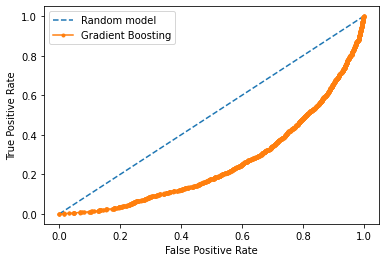

In [13]:
train_and_track_model_in_mlflow()